Epoch 1/10, Loss: 0.6738
Epoch 2/10, Loss: 0.5338
Epoch 3/10, Loss: 0.5439
Epoch 4/10, Loss: 0.4786
Epoch 5/10, Loss: 0.4551
Epoch 6/10, Loss: 0.4293
Epoch 7/10, Loss: 0.3913
Epoch 8/10, Loss: 0.3616
Epoch 9/10, Loss: 0.3217
Epoch 10/10, Loss: 0.3323
Predicted confidence: 0.00 (label: 0.0)


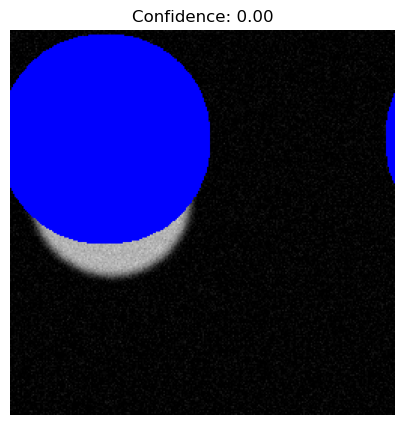

Compactness: 1.76, Fragments: 2, Area ratio: 1.16
{'area_anomaly': False, 'area_ratio': 1.1605589830401726, 'shape_irregularity': 1.7552884196696292, 'shape_flag': True, 'fragment_count': 2, 'fragment_flag': True, 'any_error': True}


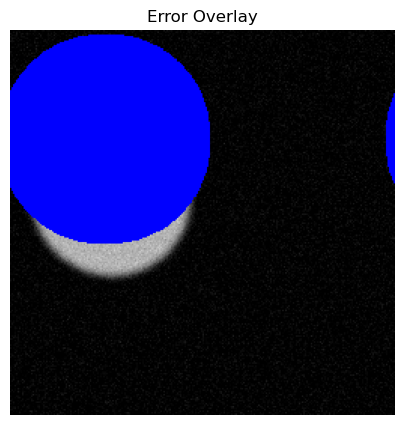

Sample 0: {'area_anomaly': False, 'area_ratio': 1.204438466576503, 'shape_irregularity': 1.1764752773625577, 'shape_flag': False, 'fragment_count': 1, 'fragment_flag': False, 'any_error': False}


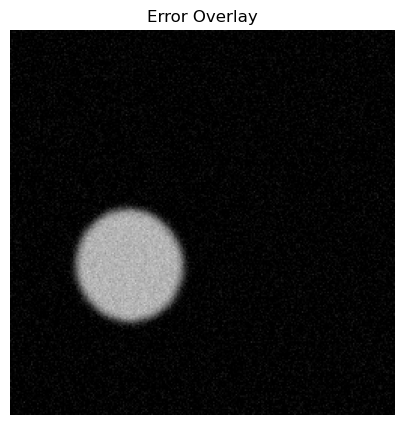

Sample 5: {'area_anomaly': False, 'area_ratio': 0.8323287670092699, 'shape_irregularity': 1.325458199078299, 'shape_flag': False, 'fragment_count': 1, 'fragment_flag': False, 'any_error': False}


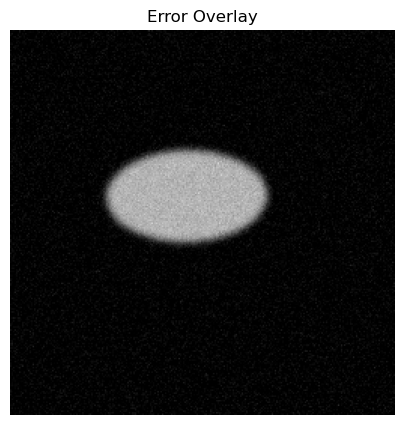

Sample 10: {'area_anomaly': True, 'area_ratio': 5.398586455391422, 'shape_irregularity': 21.39023617249558, 'shape_flag': True, 'fragment_count': 74, 'fragment_flag': True, 'any_error': True}


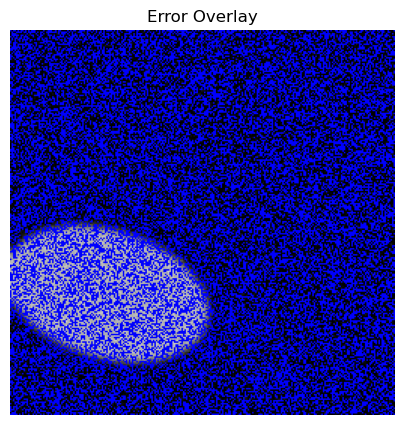

Sample 15: {'area_anomaly': False, 'area_ratio': 1.3005056582469285, 'shape_irregularity': 1.1430395599997047, 'shape_flag': False, 'fragment_count': 1, 'fragment_flag': False, 'any_error': False}


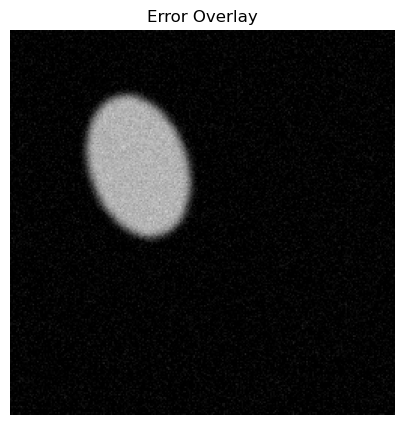

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from day3_cnn_confidence import ConfidenceNet, SegConfidenceDataset, load_sample  # import your Day-3 code if modular
from day2_error_heuristics import detect_errors, overlay_errors  # import Day-2 heuristics

plt.style.use("default")

# Paths
BASE_DIR = "../data"
IMG_DIR = os.path.join(BASE_DIR, "images")
GT_DIR = os.path.join(BASE_DIR, "masks_gt")
PRED_DIR = os.path.join(BASE_DIR, "masks_pred")
RESULT_DIR = "../results/overlays"
os.makedirs(RESULT_DIR, exist_ok=True)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConfidenceNet().to(device)

# Load saved model if you trained before
# torch.save(model.state_dict(), "../models/confidence_net.pth")
# model.load_state_dict(torch.load("../models/confidence_net.pth", map_location=device))
model.eval()


ConfidenceNet(
  (conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=1)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:
def combined_error_analysis(img, pred_mask, gt_mask=None, threshold=0.5):
    # Heuristics from Day-2
    errors = detect_errors(pred_mask, gt_mask)

    # CNN confidence
    x = np.stack([img/255.0, pred_mask/255.0], axis=0).astype(np.float32)
    x_tensor = torch.tensor(x).unsqueeze(0).to(device)
    with torch.no_grad():
        confidence = model(x_tensor).item()

    # Decide final error
    final_error_flag = errors["any_error"] or (confidence < threshold)
    
    return errors, confidence, final_error_flag


In [6]:
def overlay_combined(img, pred_mask, errors, confidence, threshold=0.5):
    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    if errors["area_anomaly"]:
        overlay[pred_mask>0] = [255,0,0]       # Red
    if errors["shape_flag"]:
        overlay[pred_mask>0] = [0,255,255]     # Yellow
    if errors["fragment_flag"]:
        overlay[pred_mask>0] = [0,0,255]       # Blue
    if confidence < threshold:
        overlay[pred_mask>0] = [128,0,128]     # Purple
    
    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Confidence: {confidence:.2f}")
    plt.show()
    
    return overlay


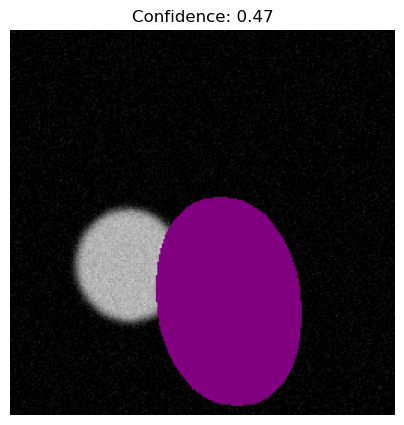

Sample 0: Errors detected: True, Confidence: 0.47


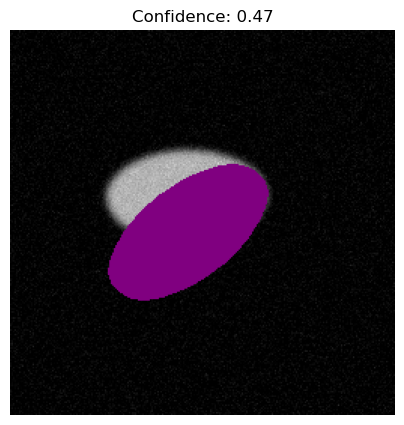

Sample 5: Errors detected: True, Confidence: 0.47


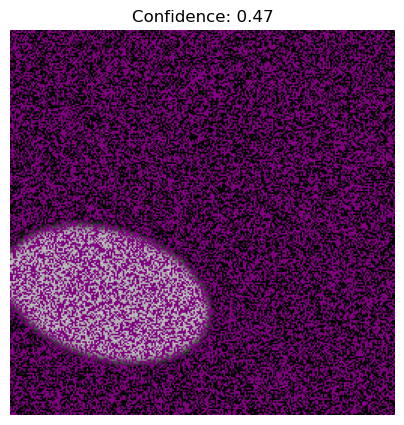

Sample 10: Errors detected: True, Confidence: 0.47


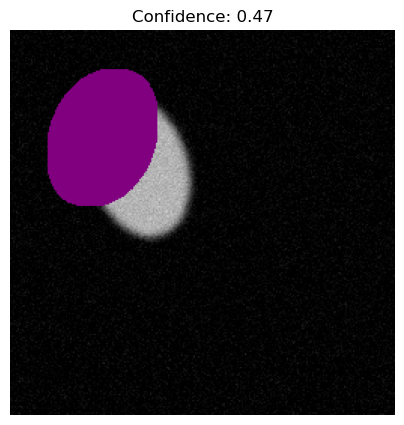

Sample 15: Errors detected: True, Confidence: 0.47


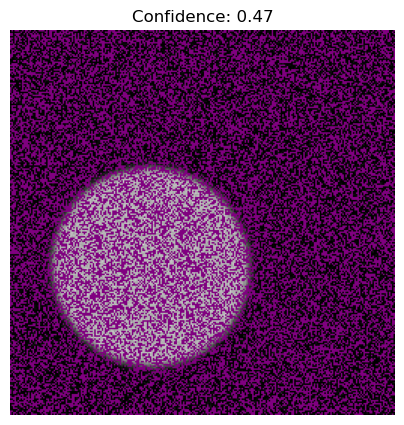

Sample 20: Errors detected: True, Confidence: 0.47


In [7]:
sample_ids = [0, 5, 10, 15, 20]

for idx in sample_ids:
    img, gt, pred = load_sample(idx)
    errors, confidence, final_flag = combined_error_analysis(img, pred, gt)
    
    overlay = overlay_combined(img, pred, errors, confidence)
    
    save_path = os.path.join(RESULT_DIR, f"sample_{idx}.png")
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    
    print(f"Sample {idx}: Errors detected: {final_flag}, Confidence: {confidence:.2f}")


In [8]:
summary = []
for idx in range(len(os.listdir(IMG_DIR))):
    img, gt, pred = load_sample(idx)
    errors, confidence, final_flag = combined_error_analysis(img, pred, gt)
    summary.append((idx, final_flag, confidence))

import pandas as pd
df = pd.DataFrame(summary, columns=["ID", "ErrorDetected", "Confidence"])
print(df.head(10))


   ID  ErrorDetected  Confidence
0   0           True    0.471997
1   1           True    0.471658
2   2           True    0.472040
3   3           True    0.471399
4   4           True    0.471149
5   5           True    0.471909
6   6           True    0.471903
7   7           True    0.470900
8   8           True    0.471071
9   9           True    0.471763
